In [1]:
library(magrittr)

In [2]:
treatment_df = readr::read_tsv('../summary/indications.tsv') %>% 
  dplyr::filter(rel_type == 'TREATS_CtD') %>%
  dplyr::select(compound_id, disease_id) %>%
  dplyr::mutate(status = 1)

Parsed with column specification:
cols(
  compound_id = col_character(),
  compound_name = col_character(),
  disease_id = col_character(),
  disease_name = col_character(),
  rel_type = col_character()
)


In [3]:
degree_prior_df = readr::read_tsv('data/degree-prior.tsv') %>%
  dplyr::mutate(Empiric = n_treatments / n_possible, Permuted = prior_perm) %>%
  dplyr::mutate(logit_prior_perm = boot::logit(prior_perm)) %>%
  dplyr::mutate(prior_theoretic = compound_treats * disease_treats) %>%
  dplyr::mutate(prior_theoretic = prior_theoretic / sum(prior_theoretic)) %>%
  dplyr::mutate(logit_prior_theoretic = boot::logit(prior_theoretic))

Parsed with column specification:
cols(
  compound_treats = col_integer(),
  disease_treats = col_integer(),
  prior_perm = col_double(),
  prior_perm_stderr = col_double(),
  n_treatments = col_integer(),
  n_possible = col_integer()
)


In [4]:
degree_prior_df %>% head(2)

compound_treats,disease_treats,prior_perm,prior_perm_stderr,n_treatments,n_possible,Empiric,Permuted,logit_prior_perm,prior_theoretic,logit_prior_theoretic
1,1,0.000329173,6.89755e-08,35,87966,0.0003978810,0.000329173,-8.018598,7.584894e-06,-11.78934
1,2,0.000659161,1.55722e-07,24,35114,0.0006834881,0.000659161,-7.323883,1.516979e-05,-11.09619


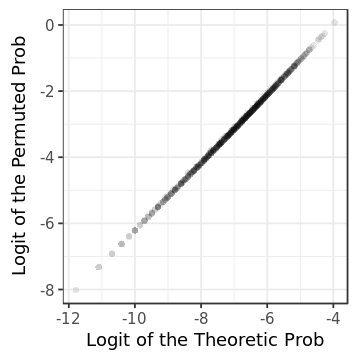

In [5]:
width = 3
height = 3
options(repr.plot.width=width, repr.plot.height=height)
gg_scatter = degree_prior_df %>%
  ggplot2::ggplot(ggplot2::aes(logit_prior_theoretic, logit_prior_perm)) +
  ggplot2::geom_point(alpha = 0.1, shape = 16) +
  ggplot2::theme_bw() +
  ggplot2::coord_equal() +
  ggplot2::xlab('Logit of the Theoretic Prob') +
  ggplot2::ylab('Logit of the Permuted Prob')

gg_scatter
ggplot2::ggsave('viz/scatter-theoretic-v-perm.png', gg_scatter, dpi = 300, width = width, height = height)

In [6]:
#lm(logit_prior_perm ~ logit_prior_theoretic, data = degree_prior_df) %>% summary

In [7]:
plot_tiles <- function(df, scale_name='') {
  gg = ggplot2::ggplot(df, ggplot2::aes(x = disease_treats, y = compound_treats, fill = prior)) +
  ggplot2::geom_tile() +
  viridis::scale_fill_viridis(scale_name) +
  ggplot2::theme_bw() +
  ggplot2::coord_equal() +
  ggplot2::theme(
    legend.position='top',
    legend.key.width=grid::unit(0.85, 'inches'),
    legend.key.size=grid::unit(0.12, 'inches')
  ) +
  ggplot2::xlab('Disease Degree') +
  ggplot2::ylab('Compound Degree') +
  ggplot2::scale_x_continuous(expand=c(0, 1)) +
  ggplot2::scale_y_continuous(expand=c(0, 1)) +
  ggplot2::theme(plot.margin = grid::unit(c(2,2,2,2), 'points'))
  return(gg)
}

In [8]:
width = 6
height = 4.5
options(repr.plot.width=width, repr.plot.height=height)

gg = degree_prior_df %>%
  tidyr::gather(kind, prior, Permuted, Empiric) %>% 
  plot_tiles('Prob') +
  ggplot2::facet_grid(kind ~ ., 'Probability') +
  ggplot2::theme(strip.background=ggplot2::element_rect(fill='#FEF2E2'))

ggplot2::ggsave('viz/prob-tiled-empiric-v-perm.png', gg, dpi = 300, width = width, height = height)

ERROR: Error: Unsupported index type: NULL


In [9]:
gg = degree_prior_df %>%
  tidyr::gather(kind, prior, Permuted, Empiric) %>% 
  dplyr::mutate(prior = log(0.01 + prior)) %>%
  plot_tiles('log(0.01 + Prob)') +
  ggplot2::facet_grid(kind ~ .) +
  ggplot2::theme(strip.background=ggplot2::element_rect(fill='#FEF2E2'))

ggplot2::ggsave('viz/log-prob-tiled-empiric-v-perm.png', gg, dpi = 300, width = width, height = height)

In [ ]:
# obs_prior_df = obs_prior_df %>% 
#   dplyr::left_join(treatment_df)

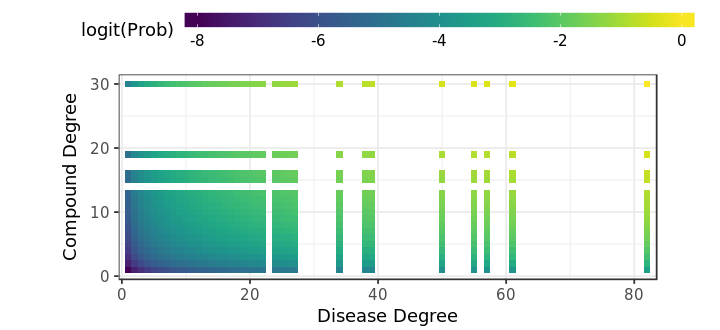

In [10]:
width = 6
height = 2.75
options(repr.plot.width=width, repr.plot.height=height)

gg_tile_logit = degree_prior_df %>% 
  dplyr::mutate(prior = boot::logit(prior_perm)) %>%
  plot_tiles('logit(Prob)')

ggplot2::ggsave('viz/logit-perm-prior-tiled.png', gg_tile_logit, dpi = 300, width = width, height = height)
plot(gg_tile_logit)

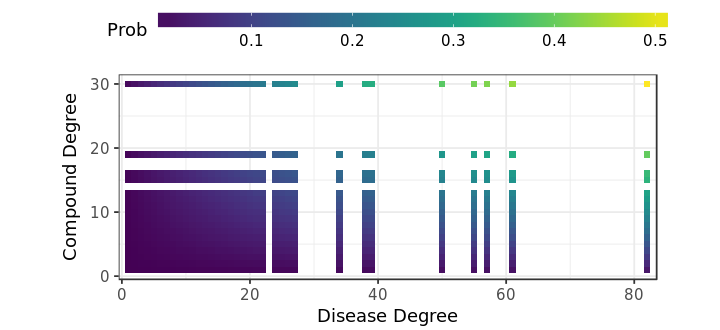

In [11]:
width = 6
height = 2.75
options(repr.plot.width=width, repr.plot.height=height)

gg_tile_prob = degree_prior_df %>%
  dplyr::mutate(prior = prior_perm) %>%
  plot_tiles('Prob')

ggplot2::ggsave('viz/perm-prior-tiled.png', gg_tile_prob, dpi = 300, width = width, height = height)
plot(gg_tile_prob)

In [12]:
obs_prior_df = readr::read_tsv('data/observation-prior.tsv')

Parsed with column specification:
cols(
  compound_id = col_character(),
  disease_id = col_character(),
  compound_treats = col_integer(),
  disease_treats = col_integer(),
  prior_perm = col_double(),
  prior_perm_stderr = col_double()
)


In [13]:
width = 6
height = 2.5
gg_hist = obs_prior_df %>%
  #dplyr::mutate(prior = prior_perm) %>%
  dplyr::mutate(logit_prior_perm = boot::logit(prior_perm)) %>%
  tidyr::gather(kind, prior, prior_perm, logit_prior_perm) %>%
  ggplot2::ggplot(ggplot2::aes(x = prior)) +
  ggplot2::geom_histogram(bins=100) +
  ggplot2::facet_wrap( ~ kind, scales='free') +
  ggplot2::theme_bw() +
  ggplot2::theme(strip.background=ggplot2::element_rect(fill='#FEF2E2')) +
  ggplot2::theme(plot.margin=grid::unit(c(2, 2, 2, 2), 'points')) +
  ggplot2::xlab('Compound–Disease Prior') +
  ggplot2::ylab('Count')
ggplot2::ggsave('viz/prob-histograms.png', gg_hist, dpi = 300, width = width, height = height)

In [ ]:
# gg = gridExtra::arrangeGrob(gg_hist, gg_tile_prob, gg_tile_logit, ncol=1)
# ggplot2::ggsave('viz/combined.png', gg, dpi = 300, width = width, height = 8, device = cairo_pdf)